# Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

Script group 29
Britt Geisler
Rob Werner
Renee Pex
Thomas van der Woude

In [ ]:
!pip install --user imageio
!pip install --user scikit-image

In [1]:
# importing useful modules and packages
import gc
import json
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

In [ ]:
## Loading the json files and creating labels



import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

# all-images files should be uploaded to the same file
imageNames = glob.glob("all-images/*")

dataset = []
labels = []

for i, imName in enumerate(imageNames):
    print(i)
    # Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break



#Converting the data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

#convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save("data/data.npy", data)
np.save("data/labels.npy", labels)

Once you save your data, you can load it from your directory.

In [2]:
import numpy as np

data = np.load('data/data.npy')
labels = np.load('data/labels.npy')

In [3]:
data.shape

(6392, 156, 156, 3)

Creating Helper Functions for usage later

In [15]:
def summarize_diagnostics(history, filename):
	
	# plotting the loss

	plt.subplot(211)
	plt.title('Loss of Model')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	plt.legend(['training_loss', 'validation_loss'])
	plt.xlabel("epoch")
	plt.ylabel("Loss")

	# Plotting the accuracy

	plt.subplot(212)
	plt.title('Accuracy of Model')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training_accuracy', 'validation_accuracy'])
	plt.xlabel("epoch")
	plt.ylabel("accuracy")
	plt.savefig(filename, bbox_inches = "tight")
	plt.show()

In [4]:

#https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))


# Preprocessing Steps



## Splitting Data

In [5]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size = 0.2, stratify=labels, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, stratify=y_trainval, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)

(4090, 156, 156, 3) (1023, 156, 156, 3) (1279, 156, 156, 3)


In [5]:
np.unique(y_test)

array(['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
       'Viral Pneumonia'], dtype='<U22')

## Normalize Data

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Normalizing the data
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_val = (X_val-X_val.min())/(X_val.max()-X_val.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())

#Encoding the data using a label encoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
print(integer_encoded)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
integer_encoded2 = label_encoder.transform(y_val)
integer_encoded2 = integer_encoded2.reshape(len(integer_encoded2), 1)
integer_encoded3 = label_encoder.transform(y_test)
integer_encoded3 = integer_encoded3.reshape(len(integer_encoded3), 1)

y_train = to_categorical(integer_encoded)
y_val = to_categorical(integer_encoded2)
y_test = to_categorical(integer_encoded3)

[3 0 0 ... 2 2 3]


# Create Baseline Model

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers


## Creating the baseline model using padding and the relu & softmax activation functions

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))


In [20]:
## checking the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 156, 156, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                  

# Analyze the performance of the baseline model

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = model.evaluate(X_test, y_test)


Epoch 1/10
128/128 [==============================] - 16s 74ms/step - loss: 0.8338 - accuracy: 0.6340 - val_loss: 0.6352 - val_accuracy: 0.7312
Epoch 2/10
128/128 [==============================] - 7s 53ms/step - loss: 0.6210 - accuracy: 0.7452 - val_loss: 0.6120 - val_accuracy: 0.7322
Epoch 3/10
128/128 [==============================] - 7s 53ms/step - loss: 0.5732 - accuracy: 0.7667 - val_loss: 0.5649 - val_accuracy: 0.7644
Epoch 4/10
128/128 [==============================] - 7s 54ms/step - loss: 0.5206 - accuracy: 0.7895 - val_loss: 0.5742 - val_accuracy: 0.7752
Epoch 5/10
128/128 [==============================] - 7s 54ms/step - loss: 0.4535 - accuracy: 0.8108 - val_loss: 0.5408 - val_accuracy: 0.7801
Epoch 6/10
128/128 [==============================] - 7s 54ms/step - loss: 0.3850 - accuracy: 0.8487 - val_loss: 0.6785 - val_accuracy: 0.7439
Epoch 7/10
128/128 [==============================] - 7s 54ms/step - loss: 0.3227 - accuracy: 0.8655 - val_loss: 0.7542 - val_accuracy: 0.713

In [23]:
## cheking the baseline's model loss and accuracy

print(test_acc, test_loss)

0.7498045563697815 0.710985541343689


40/40 [==============================] - 1s 15ms/step
[[439   1   7 117]
 [  3   5   1  16]
 [  8   0 267  46]
 [121   4  16 228]]


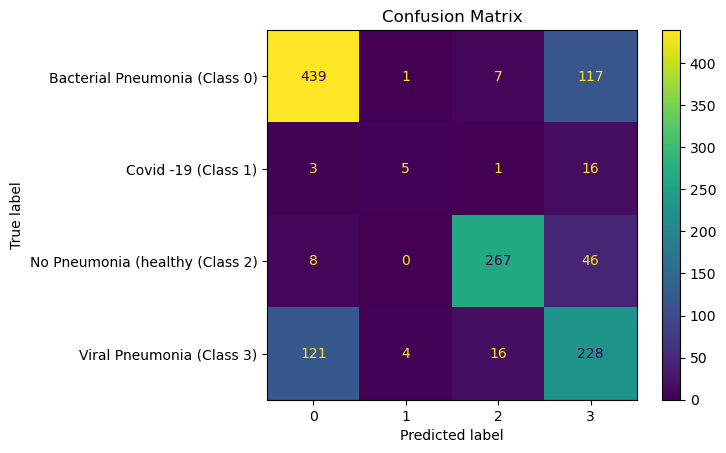

In [14]:
## Creating the confusion matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis =1).tolist()
y_pred_encoded = label_encoder.inverse_transform(y_pred)
y_test_single_value = np.argmax(y_test,axis=1).tolist()
y_test_encoded = label_encoder.inverse_transform(y_test_single_value)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_encoded, labels = label_encoder.classes_)
print(cm)


## Plotting the confusion matrix

import matplotlib.pyplot as plt
from sklearn import metrics
display_labels = ["Bacterial Pneumonia (Class 0)", "Covid -19 (Class 1)", "No Pneumonia (healthy (Class 2)", "Viral Pneumonia (Class 3)"]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.yticks([0,1,2,3], labels = display_labels)
plt.ylabel("True label")
plt.savefig("Graphs/test", bbox_inches = "tight")
plt.show()


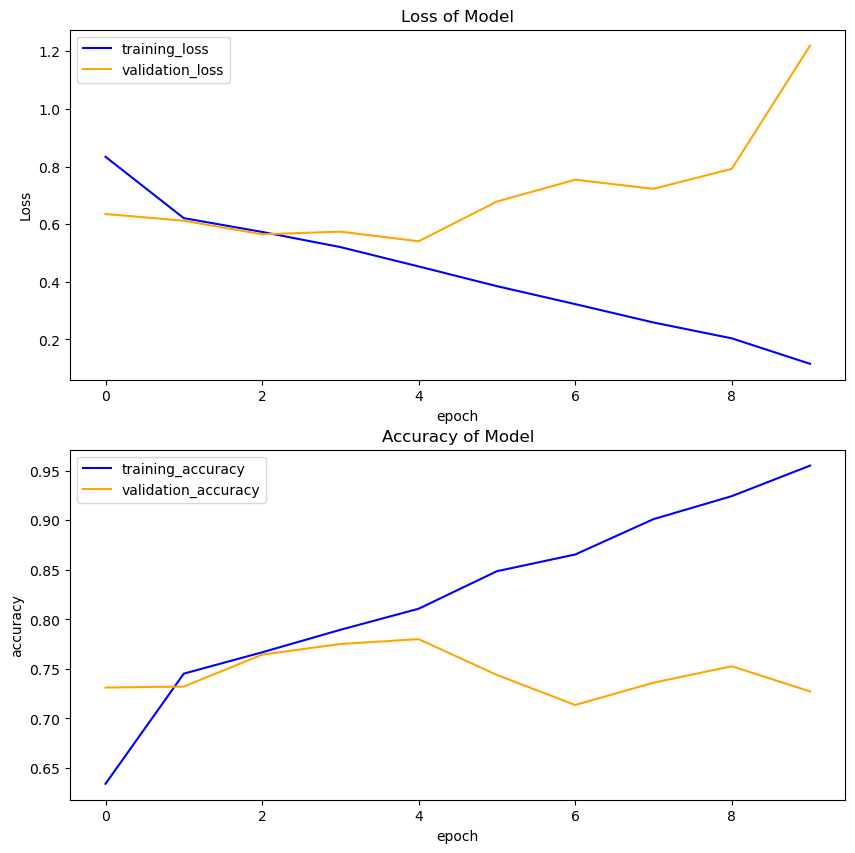

In [16]:
#Plotting the diagnostic learning curves
plt.figure(figsize=(10,10))
summarize_diagnostics(history, "Graphs/Baseline_diagnostic_Curve")


## Creating the ROC table

In [17]:
n_classes = len(np.unique(labels))
target_names = np.unique(labels)

In [19]:
y_score = model.predict(X_test)

40/40 [==============================] - 1s 15ms/step


In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_test_encoded, y_pred_encoded)
print(report)

                        precision    recall  f1-score   support

   Bacterial Pneumonia       0.77      0.78      0.77       564
              COVID-19       0.50      0.20      0.29        25
No Pneumonia (healthy)       0.92      0.83      0.87       321
       Viral Pneumonia       0.56      0.62      0.59       369

              accuracy                           0.73      1279
             macro avg       0.69      0.61      0.63      1279
          weighted avg       0.74      0.73      0.74      1279



In [21]:
#Calculating the micro AUC score

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies

fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.93


In [22]:
#Calculating the macro AUC score

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolating all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Averaging them and computing the AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


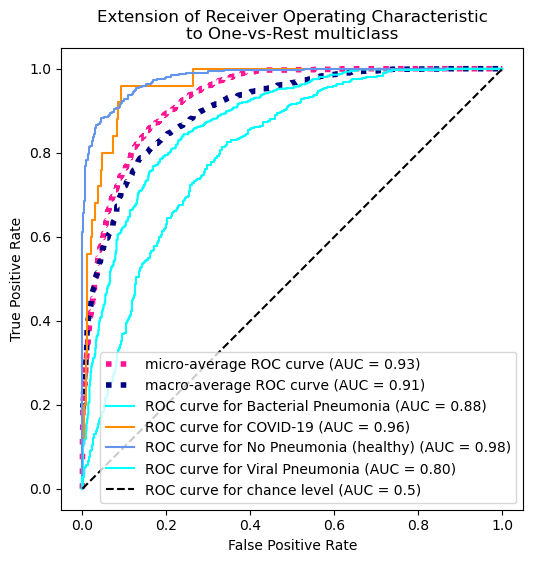

In [24]:
#plotting all ROC Curves

from sklearn.metrics import RocCurveDisplay
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.savefig("Graphs/Baseline_ROC_Curve")
plt.show()

In [68]:
# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# True positives
tp = cm.diagonal()

# False positives
fp = cm.sum(axis=0) - tp

# False negatives
fn = cm.sum(axis=1) - tp

# True negatives
tn = cm.sum() - (tp + fp + fn)

print("True positives:", tp)
print("False positives:", fp)
print("False negatives:", fn)
print("True negatives:", tn)

sensitivity = []
specificity = []
precision = []
recall = []
f1 = []
for i in range(0,4):
    sensitivity.append(tp[i]/(tp[i]+fn[i]))
    specificity.append(tn[i]/(tn[i]+fp[i]))
    precision.append(tp[i]/(tp[i]+fp[i]))
    recall.append(tp[i]/(tp[i] + fn[i]))
    f1.append(2* (precision[i]* recall[i])/(precision[i] + recall[i]))

print(sensitivity)

True positives: [414   4 289 252]
False positives: [ 92   6  53 169]
False negatives: [150  21  32 117]
True negatives: [ 623 1248  905  741]
[0.7340425531914894, 0.16, 0.9003115264797508, 0.6829268292682927]


In [73]:
print(f1)

[0.7738317757009346, 0.22857142857142856, 0.8717948717948718, 0.6379746835443039]


# Adapting/fine-tuning the network

In [151]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size = 0.2, stratify=labels, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, stratify=y_trainval, random_state = 42)



In [152]:
#Augmenting data for further model usage
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy = "minority")
train_x_sampled, y_train_sampled = sampler.fit_resample(y = y_train, X = X_train.reshape(X_train.shape[0],-1)) #Reshaping to fit the oversampler

X_train_sampled = train_x_sampled.reshape(-1,156,156,3) #Back to original image form
X_train_flipped = np.fliplr(X_train_sampled)
X_train_augmented = np.append(X_train_sampled, X_train_flipped, axis =0) # Adding both flipped and original dataset together
y_train_augmented = np.append(y_train_sampled,y_train_sampled)

In [153]:
## running the label encoder again


from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_val = (X_val-X_val.min())/(X_val.max()-X_val.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
print(integer_encoded)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
integer_encoded2 = label_encoder.transform(y_val)
integer_encoded2 = integer_encoded2.reshape(len(integer_encoded2), 1)
integer_encoded3 = label_encoder.transform(y_test)
integer_encoded3 = integer_encoded3.reshape(len(integer_encoded3), 1)
integer_encoded4 = label_encoder.transform(y_train_augmented)
integer_encoded4 = integer_encoded4.reshape(len(integer_encoded4), 1)

y_train = to_categorical(integer_encoded)
y_val = to_categorical(integer_encoded2)
y_test = to_categorical(integer_encoded3)
y_train_augmented = to_categorical(integer_encoded4)


[3 0 0 ... 2 2 3]


In [154]:
# Performing contrast stretching to improve the pictures

from skimage import exposure
import scipy.ndimage

X_val_augmented = np.copy(X_val)
X_test_augmented = np.copy(X_test)
for i, image in enumerate(X_train):
    X_train_augmented[i] =  exposure.equalize_adapthist(image)

for i, image in enumerate(X_val):
    X_val_augmented[i] =  exposure.equalize_adapthist(image)

for i, image in enumerate(X_test):
    X_test_augmented[i] =  exposure.equalize_adapthist(image)
    


Testing a multitude of models

In [144]:
#Creating a dictionary to save results
result_dictionary = {}

In [145]:
gc.collect()

28366

In [146]:
#Base model with early stopping

from tensorflow.keras import Sequential
from tensorflow.keras import layers

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["Early Stopping"] = (test_loss, test_acc)

Epoch 1/100
128/128 [==============================] - 9s 60ms/step - loss: 1.0126 - accuracy: 0.5443 - val_loss: 0.7359 - val_accuracy: 0.6833
Epoch 2/100
128/128 [==============================] - 7s 55ms/step - loss: 0.6946 - accuracy: 0.7042 - val_loss: 0.6312 - val_accuracy: 0.7107
Epoch 3/100
128/128 [==============================] - 7s 54ms/step - loss: 0.5928 - accuracy: 0.7523 - val_loss: 0.5445 - val_accuracy: 0.7683
Epoch 4/100
128/128 [==============================] - 7s 53ms/step - loss: 0.5371 - accuracy: 0.7812 - val_loss: 0.5251 - val_accuracy: 0.7801
Epoch 5/100
128/128 [==============================] - 7s 53ms/step - loss: 0.5043 - accuracy: 0.7912 - val_loss: 0.5262 - val_accuracy: 0.7771
Epoch 6/100
128/128 [==============================] - 7s 54ms/step - loss: 0.4577 - accuracy: 0.8103 - val_loss: 0.5282 - val_accuracy: 0.7879
Epoch 7/100
128/128 [==============================] - 7s 54ms/step - loss: 0.4222 - accuracy: 0.8284 - val_loss: 0.5738 - val_accuracy:

All other models will have early stopping included

In [147]:
#Model with classweights
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)
classw = generate_class_weights(class_series = y_train, multi_class=True, one_hot_encoded=True) #Tries to tackle the difference in appearence of classes
model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callback, class_weight=classw)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["Class weights"] = (test_loss, test_acc)

Epoch 1/100
128/128 [==============================] - 8s 59ms/step - loss: 1.1818 - accuracy: 0.4487 - val_loss: 0.9617 - val_accuracy: 0.4428
Epoch 2/100
128/128 [==============================] - 7s 54ms/step - loss: 0.7469 - accuracy: 0.6308 - val_loss: 0.8723 - val_accuracy: 0.6237
Epoch 3/100
128/128 [==============================] - 7s 55ms/step - loss: 0.6921 - accuracy: 0.6565 - val_loss: 0.7465 - val_accuracy: 0.6755
Epoch 4/100
128/128 [==============================] - 7s 55ms/step - loss: 0.5738 - accuracy: 0.7093 - val_loss: 0.6575 - val_accuracy: 0.7155
Epoch 5/100
128/128 [==============================] - 7s 55ms/step - loss: 0.5465 - accuracy: 0.7252 - val_loss: 0.6028 - val_accuracy: 0.7361
Epoch 6/100
128/128 [==============================] - 7s 56ms/step - loss: 0.4900 - accuracy: 0.7484 - val_loss: 0.6207 - val_accuracy: 0.7351
Epoch 7/100
128/128 [==============================] - 7s 56ms/step - loss: 0.4540 - accuracy: 0.7724 - val_loss: 0.6887 - val_accuracy:

In [156]:
#Model with oversampling, flipped images, contrast stretching

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_augmented, y_train_augmented, epochs=100, batch_size=32, validation_data=(X_val_augmented, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test_augmented, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["Augmented data"] = (test_loss, test_acc)

Epoch 1/100
364/364 [==============================] - 19s 52ms/step - loss: 1.0383 - accuracy: 0.6814 - val_loss: 1.2624 - val_accuracy: 0.4409
Epoch 2/100
364/364 [==============================] - 18s 48ms/step - loss: 0.5412 - accuracy: 0.7793 - val_loss: 1.2148 - val_accuracy: 0.4487
Epoch 3/100
364/364 [==============================] - 18s 50ms/step - loss: 0.4684 - accuracy: 0.8048 - val_loss: 1.3264 - val_accuracy: 0.4497
Epoch 4/100
364/364 [==============================] - 18s 50ms/step - loss: 0.3956 - accuracy: 0.8312 - val_loss: 1.2193 - val_accuracy: 0.4526
Epoch 5/100
364/364 [==============================] - 18s 50ms/step - loss: 0.3571 - accuracy: 0.8491 - val_loss: 1.2311 - val_accuracy: 0.4477
Epoch 6/100
364/364 [==============================] - 18s 50ms/step - loss: 0.3112 - accuracy: 0.8755 - val_loss: 1.2987 - val_accuracy: 0.4614
Epoch 7/100
364/364 [==============================] - 18s 50ms/step - loss: 0.2351 - accuracy: 0.9033 - val_loss: 1.2861 - val_ac

In [157]:
#Model with dropout

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["Dropout-model"] = (test_loss, test_acc)

Epoch 1/100
128/128 [==============================] - 10s 76ms/step - loss: 0.9124 - accuracy: 0.5958 - val_loss: 0.7885 - val_accuracy: 0.7224
Epoch 2/100
128/128 [==============================] - 9s 74ms/step - loss: 0.6657 - accuracy: 0.7134 - val_loss: 0.7528 - val_accuracy: 0.6676
Epoch 3/100
128/128 [==============================] - 9s 73ms/step - loss: 0.6120 - accuracy: 0.7381 - val_loss: 0.6014 - val_accuracy: 0.7674
Epoch 4/100
128/128 [==============================] - 9s 74ms/step - loss: 0.5657 - accuracy: 0.7658 - val_loss: 0.5710 - val_accuracy: 0.7791
Epoch 5/100
128/128 [==============================] - 9s 73ms/step - loss: 0.5229 - accuracy: 0.7863 - val_loss: 0.5717 - val_accuracy: 0.7840
Epoch 6/100
128/128 [==============================] - 9s 73ms/step - loss: 0.4792 - accuracy: 0.8051 - val_loss: 0.5565 - val_accuracy: 0.7830
Epoch 7/100
128/128 [==============================] - 9s 73ms/step - loss: 0.4344 - accuracy: 0.8142 - val_loss: 0.5967 - val_accuracy

In [158]:
#model with regularization

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same", kernel_regularizer = 'L2'))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same", kernel_regularizer = 'L2'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_regularizer = 'L2'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", kernel_regularizer = 'L2'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["L2 regularization"] = (test_loss, test_acc)

Epoch 1/100
128/128 [==============================] - 8s 60ms/step - loss: 1.3959 - accuracy: 0.5071 - val_loss: 0.8100 - val_accuracy: 0.6882
Epoch 2/100
128/128 [==============================] - 7s 57ms/step - loss: 0.7797 - accuracy: 0.7117 - val_loss: 0.6889 - val_accuracy: 0.7468
Epoch 3/100
128/128 [==============================] - 7s 57ms/step - loss: 0.6903 - accuracy: 0.7403 - val_loss: 0.6351 - val_accuracy: 0.7556
Epoch 4/100
128/128 [==============================] - 7s 56ms/step - loss: 0.6472 - accuracy: 0.7386 - val_loss: 0.6097 - val_accuracy: 0.7664
Epoch 5/100
128/128 [==============================] - 7s 57ms/step - loss: 0.6279 - accuracy: 0.7509 - val_loss: 0.6060 - val_accuracy: 0.7488
Epoch 6/100
128/128 [==============================] - 7s 57ms/step - loss: 0.6155 - accuracy: 0.7582 - val_loss: 0.6015 - val_accuracy: 0.7527
Epoch 7/100
128/128 [==============================] - 7s 56ms/step - loss: 0.6095 - accuracy: 0.7521 - val_loss: 0.6083 - val_accuracy:

In [160]:
#Model with regularization and dropout
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["Regularization and Dropout"] = (test_loss, test_acc)

Epoch 1/100
128/128 [==============================] - 11s 78ms/step - loss: 1.0162 - accuracy: 0.5389 - val_loss: 0.8805 - val_accuracy: 0.6569
Epoch 2/100
128/128 [==============================] - 9s 74ms/step - loss: 0.6903 - accuracy: 0.7012 - val_loss: 0.8031 - val_accuracy: 0.7410
Epoch 3/100
128/128 [==============================] - 9s 74ms/step - loss: 0.6102 - accuracy: 0.7489 - val_loss: 0.6495 - val_accuracy: 0.7742
Epoch 4/100
128/128 [==============================] - 9s 74ms/step - loss: 0.5871 - accuracy: 0.7631 - val_loss: 0.6865 - val_accuracy: 0.7615
Epoch 5/100
128/128 [==============================] - 9s 74ms/step - loss: 0.5309 - accuracy: 0.7868 - val_loss: 0.6390 - val_accuracy: 0.7586
Epoch 6/100
128/128 [==============================] - 9s 74ms/step - loss: 0.5249 - accuracy: 0.7853 - val_loss: 0.5729 - val_accuracy: 0.7722
Epoch 7/100
128/128 [==============================] - 9s 74ms/step - loss: 0.4800 - accuracy: 0.8061 - val_loss: 0.5444 - val_accuracy

In [159]:
#Full model combining all mentioned above

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='Softmax'))
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train_augmented, y_train_augmented, epochs=100, batch_size=32, validation_data=(X_val_augmented, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test_augmented, y_test)
gc.collect() # To ensure no OOM issues occur

result_dictionary["Full model"] = (test_loss, test_acc)

Epoch 1/100
364/364 [==============================] - 26s 69ms/step - loss: 1.9973 - accuracy: 0.6103 - val_loss: 1.2490 - val_accuracy: 0.4409
Epoch 2/100
364/364 [==============================] - 24s 66ms/step - loss: 0.7192 - accuracy: 0.6941 - val_loss: 1.1431 - val_accuracy: 0.4409
Epoch 3/100
364/364 [==============================] - 24s 66ms/step - loss: 0.5859 - accuracy: 0.7619 - val_loss: 1.2276 - val_accuracy: 0.4409
Epoch 4/100
364/364 [==============================] - 24s 66ms/step - loss: 0.5187 - accuracy: 0.7902 - val_loss: 1.2786 - val_accuracy: 0.4721
Epoch 5/100
364/364 [==============================] - 24s 67ms/step - loss: 0.4551 - accuracy: 0.8118 - val_loss: 1.4944 - val_accuracy: 0.4428
Epoch 6/100
364/364 [==============================] - 24s 66ms/step - loss: 0.4138 - accuracy: 0.8301 - val_loss: 1.4012 - val_accuracy: 0.4712
Epoch 7/100
364/364 [==============================] - 25s 67ms/step - loss: 0.3720 - accuracy: 0.8477 - val_loss: 1.3251 - val_ac

In [161]:
print(result_dictionary)

{'Early Stopping': (0.5559123754501343, 0.7748240828514099), 'Class weights': (0.5923495292663574, 0.7326036095619202), 'Augmented data': (1.2132844924926758, 0.4472244083881378), 'Dropout-model': (0.558982253074646, 0.7842063903808594), 'L2 regularization': (0.5896694660186768, 0.7646598815917969), 'Full model': (1.0829426050186157, 0.49726349115371704), 'Regularization and Dropout': (0.5619416832923889, 0.7724785208702087)}


In [69]:
def generate_best_model():
    model = Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:],  padding="same"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), activation='relu',  padding="same"))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='Softmax'))
    return model

In [70]:
#Finding the best optimzer for the best model


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

optimizers = ["SGD", "RMSprop", "Adam", "Adadelta", "Adagrad", "Adamax",  "Nadam", "Ftrl"]
optimizer_result = {}
for optimizer in optimizers:

    model = generate_best_model()
    model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    optimizer_result[optimizer] = (test_loss, test_acc)
    gc.collect() # To ensure no OOM issues occur
    


Epoch 1/100
128/128 [==============================] - 10s 75ms/step - loss: 1.0972 - accuracy: 0.4804 - val_loss: 1.2015 - val_accuracy: 0.6461
Epoch 2/100
128/128 [==============================] - 9s 70ms/step - loss: 0.8917 - accuracy: 0.6169 - val_loss: 0.9423 - val_accuracy: 0.6764
Epoch 3/100
128/128 [==============================] - 9s 67ms/step - loss: 0.7637 - accuracy: 0.6733 - val_loss: 0.9258 - val_accuracy: 0.6706
Epoch 4/100
128/128 [==============================] - 9s 69ms/step - loss: 0.7002 - accuracy: 0.7034 - val_loss: 0.8579 - val_accuracy: 0.7009
Epoch 5/100
128/128 [==============================] - 9s 69ms/step - loss: 0.6806 - accuracy: 0.7169 - val_loss: 0.8549 - val_accuracy: 0.7292
Epoch 6/100
128/128 [==============================] - 9s 67ms/step - loss: 0.6713 - accuracy: 0.7213 - val_loss: 0.7912 - val_accuracy: 0.7146
Epoch 7/100
128/128 [==============================] - 9s 67ms/step - loss: 0.6365 - accuracy: 0.7291 - val_loss: 0.8843 - val_accuracy

In [71]:
print(optimizer_result)

{'SGD': (0.5811035633087158, 0.7529319524765015), 'RMSprop': (0.5552548170089722, 0.7732603549957275), 'Adam': (0.5821772813796997, 0.7701328992843628), 'Adadelta': (0.7347880601882935, 0.7349491715431213), 'Adagrad': (0.6833598017692566, 0.7482408285140991), 'Adamax': (0.5456424951553345, 0.7818608283996582), 'Nadam': (0.594512403011322, 0.7654417753219604), 'Ftrl': (1.2415307760238647, 0.4409694969654083)}


In [72]:
#Finding the best batch size
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

batch_result = {}
batch_sizes = [1,2,4,8,16,32,64]
for batch in batch_sizes:

    model = generate_best_model()
    model.compile(optimizer = tf.keras.optimizers.Adamax(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=batch, validation_data=(X_val, y_val), callbacks= callback)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    batch_result[batch] = (test_loss, test_acc)
    gc.collect() # To ensure no OOM issues occur

Epoch 1/100
4090/4090 [==============================] - 32s 7ms/step - loss: 0.9230 - accuracy: 0.6005 - val_loss: 0.9107 - val_accuracy: 0.6579
Epoch 2/100
4090/4090 [==============================] - 30s 7ms/step - loss: 0.6579 - accuracy: 0.7249 - val_loss: 0.6758 - val_accuracy: 0.7595
Epoch 3/100
4090/4090 [==============================] - 30s 7ms/step - loss: 0.5766 - accuracy: 0.7650 - val_loss: 0.6041 - val_accuracy: 0.7771
Epoch 4/100
4090/4090 [==============================] - 30s 7ms/step - loss: 0.5329 - accuracy: 0.7814 - val_loss: 0.6511 - val_accuracy: 0.7605
Epoch 5/100
4090/4090 [==============================] - 30s 7ms/step - loss: 0.4875 - accuracy: 0.7980 - val_loss: 0.5778 - val_accuracy: 0.7566
Epoch 6/100
4090/4090 [==============================] - 30s 7ms/step - loss: 0.4476 - accuracy: 0.8225 - val_loss: 0.5688 - val_accuracy: 0.7840
Epoch 7/100
4090/4090 [==============================] - 30s 7ms/step - loss: 0.4045 - accuracy: 0.8372 - val_loss: 0.6144 -

In [73]:
print(batch_result)

{1: (0.575173556804657, 0.7756059169769287), 2: (0.5570575594902039, 0.7842063903808594), 4: (0.5493687391281128, 0.7802971005439758), 8: (0.5462767481803894, 0.7709147930145264), 16: (0.5635200142860413, 0.7935887575149536), 32: (0.5660108327865601, 0.7685691714286804), 64: (0.5748212933540344, 0.7779515385627747)}


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

model = generate_best_model()
model.compile(optimizer = tf.keras.optimizers.Adamax(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect() # To ensure no OOM issues occur

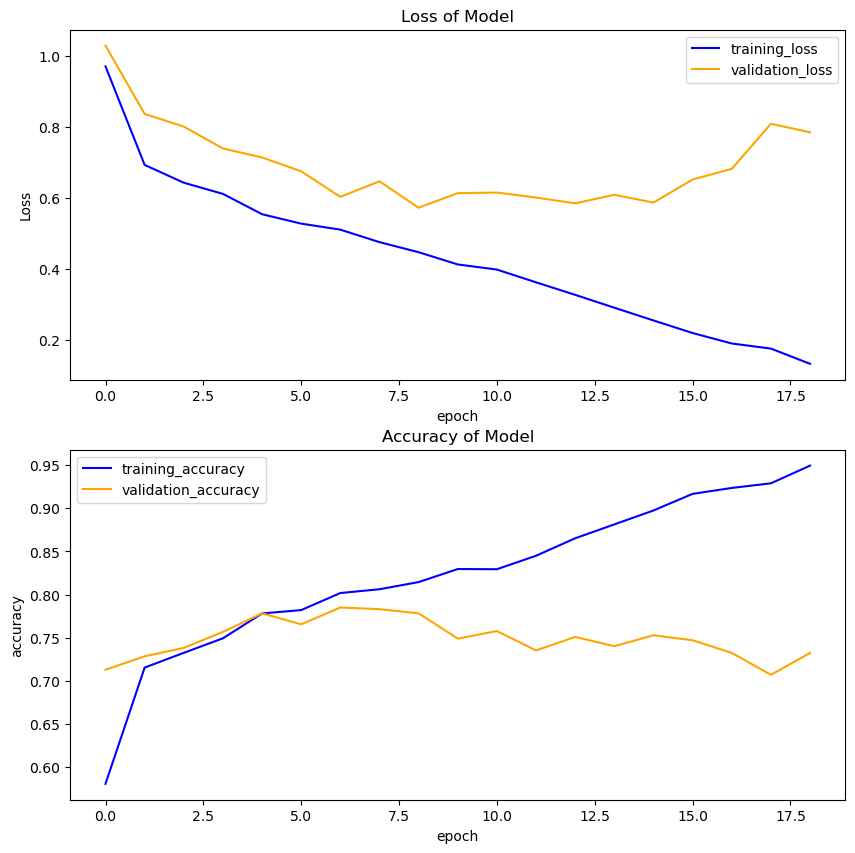

In [77]:
# Plotting the  diagnostic learning curves

plt.figure(figsize=(10,10))
summarize_diagnostics(history, "Graphs/Diagnositcs_Improved_Model")

40/40 [==============================] - 1s 16ms/step
[[484   1  10  69]
 [  0   1   0  24]
 [ 16   0 289  16]
 [123   2  17 227]]


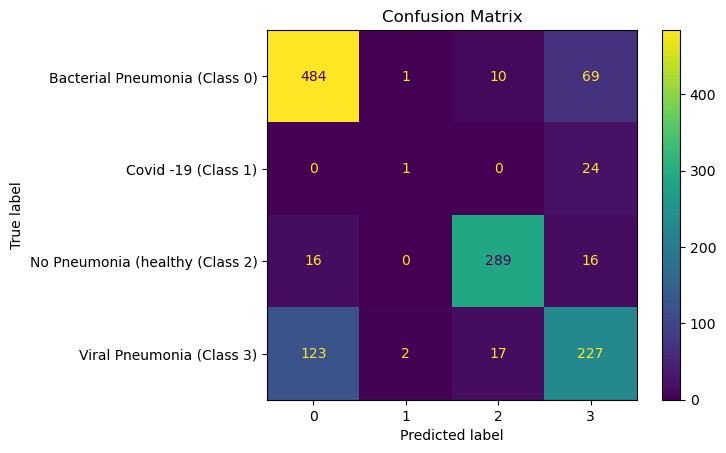

In [78]:
## Creating a new confusion matrix for our updated model

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis =1).tolist()
y_pred_encoded = label_encoder.inverse_transform(y_pred)
y_test_single_value = np.argmax(y_test,axis=1).tolist()
y_test_encoded = label_encoder.inverse_transform(y_test_single_value)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_encoded, labels = label_encoder.classes_)
print(cm)


## Plotting the confusion matrix

import matplotlib.pyplot as plt
from sklearn import metrics
display_labels = ["Bacterial Pneumonia (Class 0)", "Covid -19 (Class 1)", "No Pneumonia (healthy (Class 2)", "Viral Pneumonia (Class 3)"]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.yticks([0,1,2,3], labels = display_labels)
plt.savefig("Graphs/Improved_Model_Confusion", bbox_inches = "tight")
plt.ylabel("True label")

plt.show()

In [33]:
n_classes = len(np.unique(labels))
print(n_classes)

target_names = np.unique(labels)

4


In [34]:
y_test2 = np.asarray(y_test2)
y_pred = np.asarray(y_pred)


In [80]:
y_score = model.predict(X_test)

40/40 [==============================] - 1s 21ms/step


In [81]:
#Calculating the micro AUC score

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies

fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.95


In [82]:
#Calculating the macro AUC score

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolating all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Averaging them and computing the AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.93


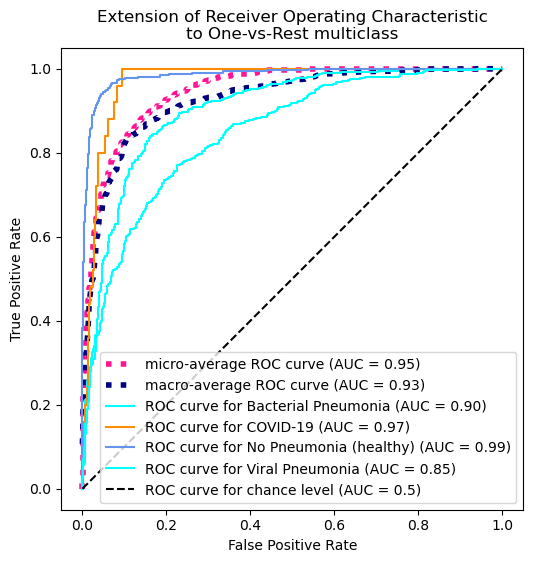

In [83]:
#plotting all ROC Curves

from sklearn.metrics import RocCurveDisplay
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.savefig("Graphs/Improved_Model_ROC", bbox_inches = "tight")
plt.show()

In [87]:
# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# True positives
tp = cm.diagonal()

# False positives
fp = cm.sum(axis=0) - tp

# False negatives
fn = cm.sum(axis=1) - tp

# True negatives
tn = cm.sum() - (tp + fp + fn)

print("True positives:", tp)
print("False positives:", fp)
print("False negatives:", fn)
print("True negatives:", tn)

sensitivity = []
specificity = []
precision = []
recall = []
f1 = []
for i in range(0,4):
    sensitivity.append(tp[i]/(tp[i]+fn[i]))
    specificity.append(tn[i]/(tn[i]+fp[i]))
    precision.append(tp[i]/(tp[i]+fp[i]))
    f1.append(2* (precision[i]* sensitivity[i])/(precision[i] + sensitivity[i]))

print(f1)

True positives: [484   1 289 227]
False positives: [139   3  27 109]
False negatives: [ 80  24  32 142]
True negatives: [ 576 1251  931  801]
[0.8155012636899747, 0.06896551724137932, 0.9073783359497645, 0.6439716312056738]


# Transfer Learning

In [91]:
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(156,156,3),
                                                  pooling="avg", classes=4,
                                                  weights="imagenet")
pretrained_model.trainable = False
pretrained_model.summary()

#add the last layers for specific problem
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(32, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

#compile and fit the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 156, 156, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 162, 162, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 78, 78, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 78, 78, 64)   256         ['conv1_conv[0][0]']      

54949

In [44]:
from tensorflow.keras.applications.vgg16 import VGG16
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose= 1, restore_best_weights=True)

#from tensorflow.keras.applications.vgg16 import preprocess_input

print(X_train[0].shape)
print(y_train[0].shape)
print(y_val[0].shape)

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

base_model.summary()

#add the last layers for specific problem
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(32, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

#compile and fit the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val), callbacks= callback)
test_loss, test_acc = model.evaluate(X_test, y_test)
gc.collect()

(156, 156, 3)
(4,)
(4,)
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 3

34359

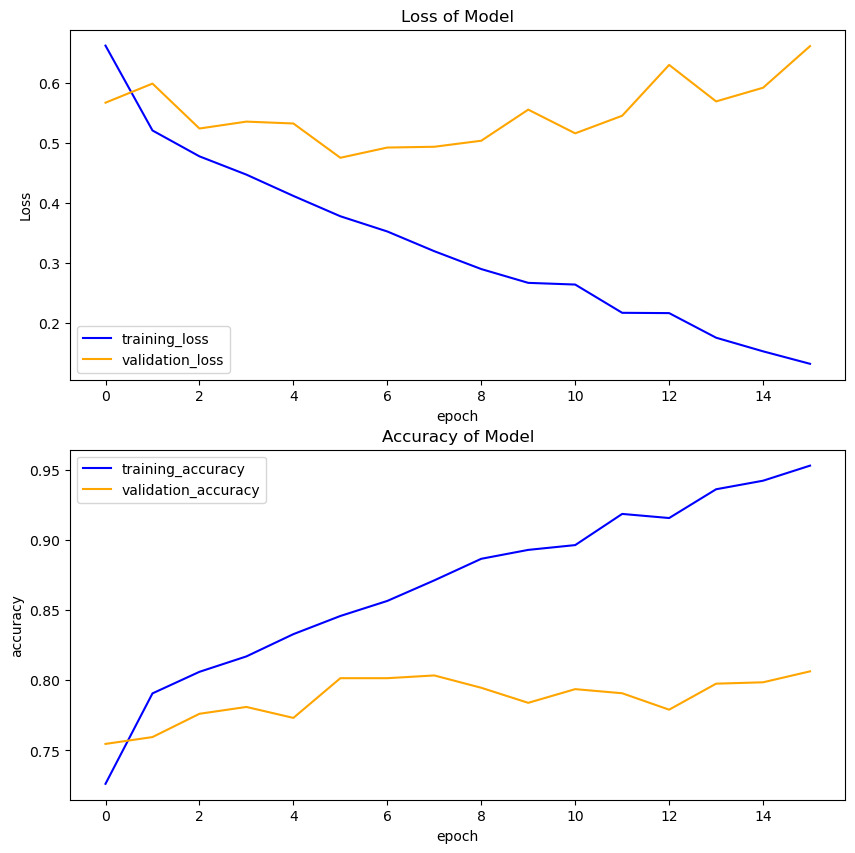

In [45]:
# Plotting the  diagnostic learning curves

plt.figure(figsize=(10,10))
summarize_diagnostics(history, "Graphs/Transfer_Learning_Diagnostics")

40/40 [==============================] - 2s 54ms/step
[[482   1   9  72]
 [  0   3   2  20]
 [  4   1 307   9]
 [123   0  19 227]]


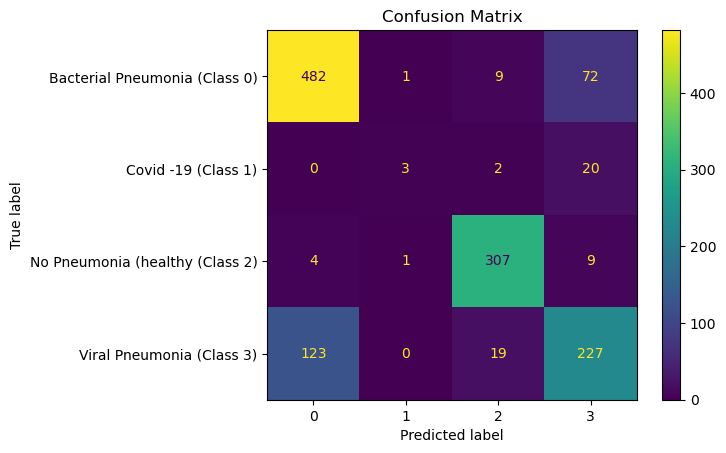

In [60]:
## Creating a new confusion matrix for our updated model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis =1).tolist()
y_pred_encoded = label_encoder.inverse_transform(y_pred)
y_test_single_value = np.argmax(y_test,axis=1).tolist()
y_test_encoded = label_encoder.inverse_transform(y_test_single_value)
                                                 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_encoded, y_pred_encoded, labels = label_encoder.classes_)
print(cm)


## Plotting the confusion matrix

import matplotlib.pyplot as plt
from sklearn import metrics
display_labels = ["Bacterial Pneumonia (Class 0)", "Covid -19 (Class 1)", "No Pneumonia (healthy (Class 2)", "Viral Pneumonia (Class 3)"]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.yticks([0,1,2,3], labels = display_labels)
plt.ylabel("True label")
plt.savefig("Graphs/Transfer_Learning_Confusion", bbox_inches = "tight")
plt.show()

In [61]:
n_classes = len(np.unique(labels))
print(n_classes)

target_names = np.unique(labels)

4


In [62]:
y_test2 = np.asarray(y_test2)
y_pred = np.asarray(y_pred)


In [63]:
y_score = model.predict(X_test)

40/40 [==============================] - 2s 53ms/step


In [52]:
#Calculating the micro AUC score

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies

fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96


In [53]:
#Calculating the macro AUC score

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolating all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Averaging them and computing the AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.94


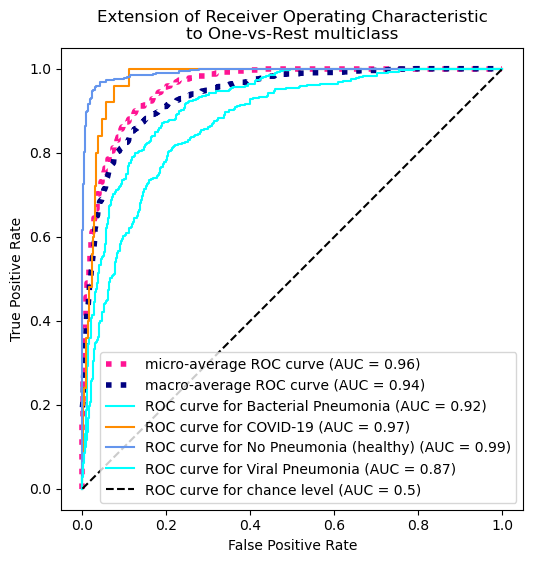

In [54]:
#plotting all ROC Curves

from sklearn.metrics import RocCurveDisplay
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.savefig("GraphsTransfer_Model_ROC", bbox_inches = "tight")
plt.show()

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# True positives
tp = cm.diagonal()

# False positives
fp = cm.sum(axis=0) - tp

# False negatives
fn = cm.sum(axis=1) - tp

# True negatives
tn = cm.sum() - (tp + fp + fn)

print("True positives:", tp)
print("False positives:", fp)
print("False negatives:", fn)
print("True negatives:", tn)

sensitivity = []
specificity = []
precision = []
recall = []
f1 = []
for i in range(0,4):
    sensitivity.append(tp[i]/(tp[i]+fn[i]))
    specificity.append(tn[i]/(tn[i]+fp[i]))
    precision.append(tp[i]/(tp[i]+fp[i]))
    f1.append(2* (precision[i]* sensitivity[i])/(precision[i] + sensitivity[i]))

print(f1)

True positives: [482   3 307 227]
False positives: [127   2  30 101]
False negatives: [ 82  22  14 142]
True negatives: [ 588 1252  928  809]
[0.8218243819266837, 0.19999999999999998, 0.9331306990881459, 0.6513629842180775]
